In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import pyro
from pyro.contrib import gp
from scipy import stats
from bb_opt.src.bayesian_opt import (
    normal_priors,
    normal_variationals,
    make_bnn_model,
    make_guide,
    train,
    bnn_predict
)

%matplotlib inline

In [5]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 1D Functions

In [ ]:
gp.kernels.Kernel()

In [80]:
n_inputs = 1
n_hidden = 128
non_linearity = 'ReLU'
batch_size = 16
n_train = 256

model = nn.Sequential(
    nn.Linear(n_inputs, n_hidden),
    getattr(nn, non_linearity)(),
    nn.Linear(n_hidden, n_hidden),
    getattr(nn, non_linearity)(),
    nn.Linear(n_hidden, 1)
).to(device)

In [81]:
def f(x):
    return np.sin(x)

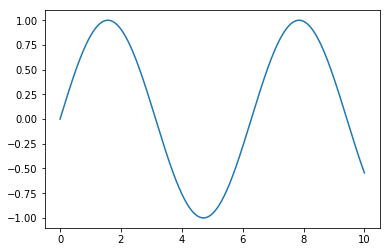

In [82]:
min_x = 0
max_x = 10

x = np.linspace(min_x, max_x, 1000)
plt.plot(x, f(x))

In [83]:
prior_mean = 0
prior_std = .05

priors = lambda: normal_priors(model, prior_mean, prior_std)
variationals = lambda: normal_variationals(model, prior_mean, prior_std)
bnn_model = make_bnn_model(model, priors, batch_size=batch_size)
guide = make_guide(model, variationals)

In [84]:
optimizer = pyro.optim.Adam({})
pyro.clear_param_store()
svi = pyro.infer.SVI(bnn_model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

losses = []

In [85]:
train_inputs = np.random.uniform(min_x, max_x, (n_train, 1))
train_labels = f(train_inputs)

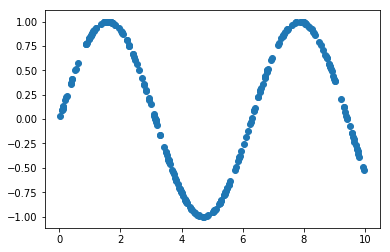

In [86]:
plt.scatter(train_inputs, train_labels)

In [87]:
train_inputs_device = torch.tensor(train_inputs).float().to(device)
train_labels_device = torch.tensor(train_labels).float().to(device)

In [88]:
losses += train(svi, 10_000, train_inputs_device, train_labels_device, verbose=True)

[S0000] loss: 3,483,482
[S0500] loss: 2,225,634
[S1000] loss: 1,801,719
[S1500] loss: 1,316,261
[S2000] loss: 1,131,460
[S2500] loss: 1,147,890
[S3000] loss: 925,306
[S3500] loss: 1,056,074
[S4000] loss: 770,887
[S4500] loss: 715,227
[S5000] loss: 669,982
[S5500] loss: 662,547
[S6000] loss: 585,810
[S6500] loss: 529,405
[S7000] loss: 488,378
[S7500] loss: 446,588
[S8000] loss: 401,144
[S8500] loss: 406,204
[S9000] loss: 332,450
[S9500] loss: 386,128


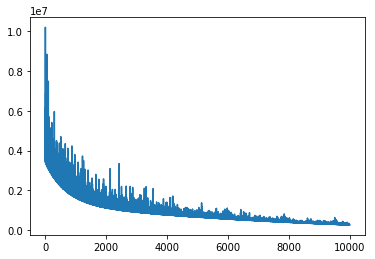

In [89]:
plt.plot(losses)

In [90]:
preds = bnn_predict(guide, train_inputs_device, n_samples=100)
mean = preds.mean(axis=0)
std = preds.std(axis=0)

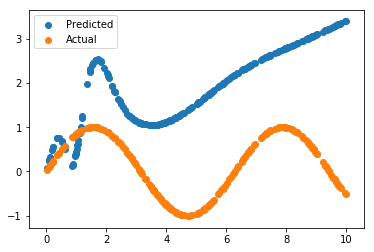

In [91]:
# n_inputs = 1
# n_hidden = 128
# non_linearity = 'ReLU'
# batch_size = 16
# n_train = 256

# model = nn.Sequential(
#     nn.Linear(n_inputs, n_hidden),
#     getattr(nn, non_linearity)(),
#     nn.Linear(n_hidden, n_hidden),
#     getattr(nn, non_linearity)(),
#     nn.Linear(n_hidden, 1)
# ).to(device)

plt.scatter(train_inputs, mean, label='Predicted')
plt.scatter(train_inputs, train_labels, label='Actual')
plt.legend()

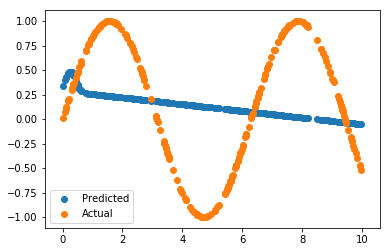

In [70]:
# n_inputs = 1
# n_hidden = 256
# non_linearity = 'ReLU'
# batch_size = 16
# n_train = 256

# model = nn.Sequential(
#     nn.Linear(n_inputs, n_hidden),
#     getattr(nn, non_linearity)(),
#     nn.Linear(n_hidden, 1)
# ).to(device)

plt.scatter(train_inputs, mean, label='Predicted')
plt.scatter(train_inputs, train_labels, label='Actual')
plt.legend()

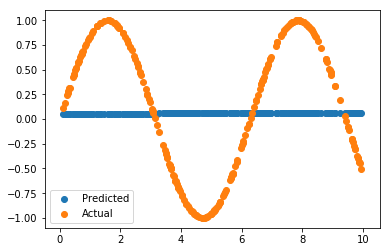

In [57]:
# n_inputs = 1
# n_hidden = 10
# non_linearity = 'ReLU'
# batch_size = 16
# n_train = 256

# model = nn.Sequential(
#     nn.Linear(n_inputs, n_hidden),
#     getattr(nn, non_linearity)(),
#     nn.Linear(n_hidden, 1)
# ).to(device)

plt.scatter(train_inputs, mean, label='Predicted')
plt.scatter(train_inputs, train_labels, label='Actual')
plt.legend()

# Classic BO
 In PDTS, their real-world examples (all?) have a discrete set of molecules small enough that they can evaluate the network on all of them to find the predicted best one; it's not clear what they did for the continuous problems. One might consider sampling points randomly from the space and then doing a gradient ascent on each; see if, after a certain number of points, you converge to a (probable) best value.
 
But I think it would be more consistent to just bin the quantize the points (given that we know a max and min value for each function). We can make this quite fine, since the ranges are small, and we're okay with a large number of options. Making each point categorical loses a lot of information, though, if the functions are smooth at all (which they are).

Ohh, they used a GP not an NN for this section.

In [4]:
import classics

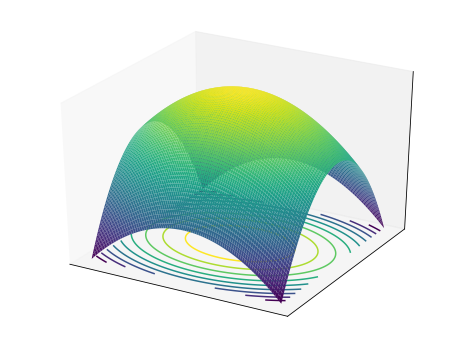

In [5]:
func = classics.Bohachevsky()
plot_contours(func, func.bounds);

In [6]:
n_hidden = 100
model = nn.Sequential(
    nn.Linear(func.ndim, n_hidden),
    nn.ReLU(),
    nn.Linear(n_hidden, 1)
).to(device)

How many points do we need to check in the input space before we get a good idea of what the model thinks the max is?
  * It seems like not very many (e.g. 1,000), even without doing gradient ascent, but this is certainly problem specific and might also change as the network is trained.

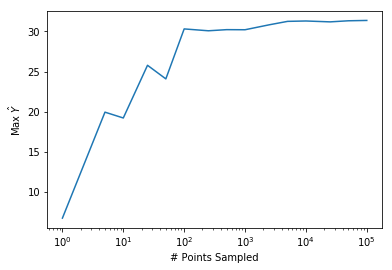

In [76]:
n_points = [1, 5, 10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10_000, 25_000, 50_000, 100_000]
max_y = []

for i in range(len(n_points)):
    points = random_points(func.bounds, func.ndim, n_points[i])
    pred_y = model(torch.tensor(points).float().to(device))
    max_y.append(pred_y.max().item())

plt.plot(n_points, max_y)
plt.xlabel('# Points Sampled')
plt.ylabel('Max $\hat Y$')
plt.xscale('log')
plt.rc('font', size=10)

What works better - constraining the input every $k$ steps or just once at the end? What is a good value of $k$?
  * Hard to tell here because the same value is always the best...

In [77]:
n_points = 1000
n_optimizer_steps = 10000
constrain_steps = [1, 5, 10, 25, 50, 100, 250, 500, 1000, n_optimizer_steps + 1]

points = random_points(func.bounds, func.ndim, n_points)
raw_inputs = torch.tensor(points).float().to(device)

y_maxes = []
x_bests = []

for constrain_every in constrain_steps:
    inputs = raw_inputs.clone().requires_grad_()
    input_optimizer = torch.optim.Adam([inputs])

    optimize_inputs(inputs, input_optimizer, model, n_optimizer_steps, constrain_every)
    
    y_pred = model(inputs)
    y_max = y_pred.max().item()
    x_best = inputs[y_pred.argmax()].detach().cpu().numpy()

    y_maxes.append(y_max)
    x_bests.append(x_best)

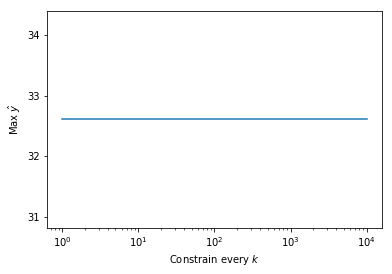

In [78]:
plt.plot(constrain_steps, y_maxes)
plt.xlabel('Constrain every $k$')
plt.ylabel('Max $\hat y$')
plt.xscale('log')
plt.rc('font', size=15)

In [79]:
x_bests

[array([-105.26803,  -93.70713], dtype=float32),
 array([-105.26803,  -93.70713], dtype=float32),
 array([-105.26803,  -93.70713], dtype=float32),
 array([-105.26803,  -93.70713], dtype=float32),
 array([-105.26803,  -93.70713], dtype=float32),
 array([-105.26803,  -93.70713], dtype=float32),
 array([-105.26803,  -93.70713], dtype=float32),
 array([-105.26803,  -93.70713], dtype=float32),
 array([-105.26803,  -93.70713], dtype=float32),
 array([-105.26803,  -93.70713], dtype=float32)]

## @

In [7]:
prior_mean = 0
prior_std = .05
batch_size = 64
n_points = 500
n_optimizer_steps = 500
constrain_every = 1

In [8]:
def get_new_inputs(n_inputs: int, guide, bounds, ndim: int, n_sample_points: int, n_optimizer_steps: int, constrain_every: int):
    new_inputs = []
    for _ in range(n_inputs):
        nn_sample = guide()
        sample_points = random_points(bounds, ndim, n_sample_points)
        sample_points = torch.tensor(sample_points).float().to(device).requires_grad_()
        input_optimizer = torch.optim.Adam([sample_points])

        optimize_inputs(sample_points, input_optimizer, nn_sample, n_optimizer_steps, constrain_every, bounds)

        y_pred = nn_sample(sample_points)
        x_best = sample_points[y_pred.argmax()].detach()
        new_inputs.append(x_best)
    return torch.cat([inputs[None, ...] for inputs in new_inputs])

In [9]:
# TODO: can we use an auto guide for this?
bnn_model = make_bnn_model(model, normal_priors(model, prior_mean, prior_std), batch_size=batch_size)
guide = make_guide(model, normal_variationals(model, prior_mean, prior_std))

In [10]:
def eval_on_grid(guide, bounds, device: torch.device, n_samples: int=50, n_points: int=100):
    xs = np.linspace(*bounds[0], n_points)
    ys = np.linspace(*bounds[1], n_points)
    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack((xs, ys), axis=-1)
    grid = torch.tensor(grid).float().to(device)

    preds = []
    for _ in range(n_samples):
        nn_sample = guide()
        preds.append(nn_sample(grid).detach().cpu().squeeze().numpy())
    return np.stack(preds, axis=-1).mean(axis=-1)

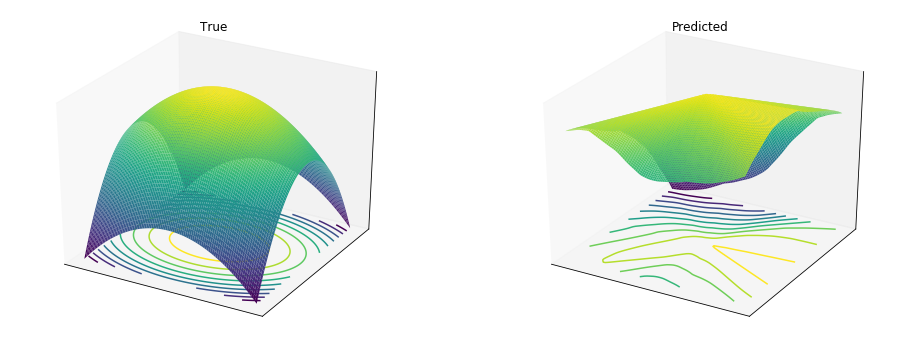

In [11]:
ax = plot_contours([func, eval_on_grid(guide, func.bounds, device)], func.bounds, titles=['True', 'Predicted'])

In [12]:
# for the first batch, select the points at random from the space
inputs = random_points(func.bounds, func.ndim, n_points=batch_size)
labels = func(inputs)

inputs = torch.tensor(inputs).float().to(device)
labels = torch.tensor(labels).float().to(device)

In [13]:
p = guide()(inputs)
((p - labels) ** 2).sum()

tensor(5.5548e+11, device='cuda:0')

In [14]:
optimizer = pyro.optim.Adam({})
pyro.clear_param_store()
svi = pyro.infer.SVI(bnn_model, guide, optimizer, loss=pyro.infer.Trace_ELBO())

losses = []

In [15]:
losses += train(10000, inputs, labels, verbose=True)

[S0000] loss: 4,199,420,420
[S0500] loss: 4,170,811,540
[S1000] loss: 4,202,944,901
[S1500] loss: 4,270,172,147
[S2000] loss: 4,165,101,232
[S2500] loss: 4,312,834,993
[S3000] loss: 4,316,127,295
[S3500] loss: 4,205,291,801
[S4000] loss: 4,259,657,852
[S4500] loss: 4,237,241,533
[S5000] loss: 4,245,664,556
[S5500] loss: 4,267,589,263
[S6000] loss: 4,158,559,973
[S6500] loss: 4,222,070,919
[S7000] loss: 4,251,729,190
[S7500] loss: 4,194,204,358
[S8000] loss: 4,163,532,590
[S8500] loss: 4,308,883,799
[S9000] loss: 4,199,658,550
[S9500] loss: 4,222,258,226


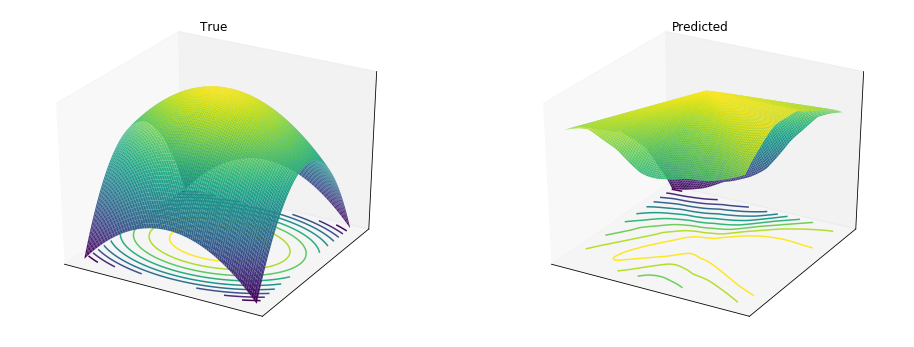

In [16]:
plot_contours([func, eval_on_grid(guide, func.bounds, device)], func.bounds, titles=['True', 'Predicted'])

In [ ]:
inputs = get_new_inputs(batch_size, guide, func.bounds, func.ndim, n_points, n_optimizer_steps, constrain_every)

labels = func(inputs.cpu().numpy())
labels = torch.tensor(labels).float().to(device)

In [17]:
inputs = random_points(func.bounds, func.ndim, n_points=batch_size)

labels = (inputs ** 2).mean(axis=1)
# labels = func(inputs)

inputs = torch.tensor(inputs).float().to(device)
labels = torch.tensor(labels).float().to(device)

In [30]:
n_hidden = 256
nn_sample = nn.Sequential(
  nn.Linear(in_features=2, out_features=n_hidden),
  nn.Tanh(),
  nn.Linear(in_features=n_hidden, out_features=1)
)

In [31]:
optimizer = torch.optim.Adam(nn_sample.parameters())
loss_func = nn.MSELoss()

In [32]:
for epoch in range(100):
    optimizer.zero_grad()
    predictions = model(inputs).squeeze()
    loss = loss_func(predictions, labels)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'[E{epoch}] Loss = {loss.item():,.3f}.')

[E0] Loss = 17,674,236.000.
[E10] Loss = 17,674,236.000.
[E20] Loss = 17,674,236.000.
[E30] Loss = 17,674,236.000.
[E40] Loss = 17,674,236.000.
[E50] Loss = 17,674,236.000.
[E60] Loss = 17,674,236.000.
[E70] Loss = 17,674,236.000.
[E80] Loss = 17,674,236.000.
[E90] Loss = 17,674,236.000.


In [45]:
def jointplot(*args, **kwargs):
    ax = sns.jointplot(*args, **kwargs, s=5, alpha=0.3)
    ax.set_axis_labels('Predicted', 'Actual')

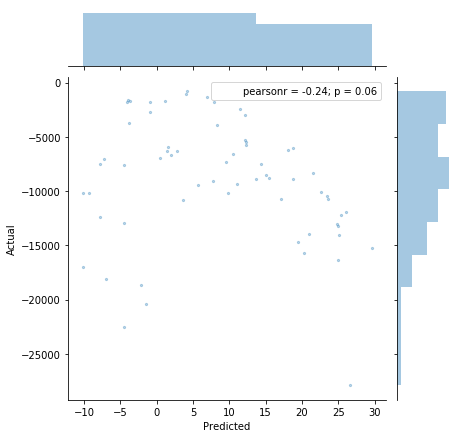

In [55]:
preds = model(inputs).detach().cpu().squeeze().numpy()
jointplot(preds, labels.cpu().numpy())

In [11]:
params = []
for name, param in model.named_parameters():
    params.append(np.array(param.detach()))

In [12]:
params = np.concatenate([p.ravel() for p in params])

In [13]:
np.mean(params), np.std(params), len(params)

(-0.0003324937, 0.046117462, 47489)